Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

__NOTE__ to the user: In first use, this notebook cannot be run top to bottom. It assumes that you have a bunch of csv files that are created at different points in the notebook.

In [1]:
import pandas as pd
import numpy as np
import os.path
from nlpUtils import aardvark as aa 

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import f1_score # auc if I get embeddings


#import emoji  # https://pypi.org/project/emoji/

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
# sns.set(font_scale=1.5)

from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords as nltkStop
from nltk import ngrams
#from nltk.tokenize import sent_tokenize  # Creates a list of sentences
#from nltk.tokenize import TweetTokenizer  # Prefered: tokenizes a text, with extra controls


In [17]:
import importlib
importlib.reload(aa)

<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

### NOTE
For VADER, I will have to create a dictionary of these codes as "words" that can be added to the lexicon.
* keep the scores from the emosent library as the prioirity
* Use the VADER score as a backup
* Manually check the results to make sure they are reasonable and identify ones to customize.

## _____________ FUNCTIONS ____________

In [ ]:
# create the sentiment intensity dictionary object
# sid = SentimentIntensityAnalyzer()  #NOTE: this NEEDS to stay outside of the functions. I will be modifying it.

# FROM aardvark
# creates the sentiment intensity dictionary: aa.vader_sid(tweet)
# gets the compound score: aa.vader_sent_compound(tweet)
# gets the classification of the compund score using the authors' suggested cutoff points: aa.vader_pred(tweet, pos_cut, neg_cut)


# Setup
Assumes that you have completed dataCleaningB and dataSplitBalance

In [2]:
# Import the files that result from dataSplitBalance

unbal_x_train = pd.read_csv("dataBalancedSets/unbal_x_train.csv", header=0, index_col=0)
unbal_x_val = pd.read_csv("dataBalancedSets/unbal_x_val.csv", header=0, index_col=0)
unbal_y_train = pd.read_csv("dataBalancedSets/unbal_y_train.csv", header=0, index_col=0)
unbal_y_val = pd.read_csv("dataBalancedSets/unbal_y_val.csv", header=0, index_col=0)

under_x_train = pd.read_csv("dataBalancedSets/under_x_train.csv", header=0, index_col=0)
under_x_val = pd.read_csv("dataBalancedSets/under_x_val.csv", header=0, index_col=0)
under_y_train = pd.read_csv("dataBalancedSets/under_y_train.csv", header=0, index_col=0)
under_y_val = pd.read_csv("dataBalancedSets/under_y_val.csv", header=0, index_col=0)

underOver_y_train = pd.read_csv("dataBalancedSets/underOver_y_train.csv", header=0, index_col=0)
underOver_x_train = pd.read_csv("dataBalancedSets/underOver_x_train.csv", header=0, index_col=0)
underOver_y_val = pd.read_csv("dataBalancedSets/underOver_y_val.csv", header=0, index_col=0)
underOver_x_val = pd.read_csv("dataBalancedSets/underOver_x_val.csv", header=0, index_col=0)

# And the test dataset
x_test = pd.read_csv("dataBalancedSets/x_test.csv", header=0, index_col=0)
y_test = pd.read_csv("dataBalancedSets/y_test_sent.csv", header=0, index_col=0)

print("Unbalanced:")
print("x-train:", unbal_x_train.shape, "x-val:", unbal_x_val.shape, "y-train:", unbal_y_train.shape, "y-val:", unbal_y_val.shape)
print("Undersampled")
print("x-train:", under_x_train.shape, "x-val:", under_x_val.shape, "y-train:", under_y_train.shape, "y-val:", under_y_val.shape)
print("Under-Oversampled")
print("x-train:", underOver_x_train.shape, "x-val:", underOver_x_val.shape, "y-train:", underOver_y_train.shape, "y-val:", underOver_y_val.shape)
print("TEST DATA")
print("x-TEST:", x_test.shape, "y-TEST:", y_test.shape)


Unbalanced:
x-train: (823, 3) x-val: (206, 3) y-train: (823, 5) y-val: (206, 5)
Undersampled
x-train: (574, 3) x-val: (144, 3) y-train: (574, 5) y-val: (144, 5)
Under-Oversampled
x-train: (982, 3) x-val: (247, 3) y-train: (982, 5) y-val: (247, 5)
TEST DATA
x-TEST: (182, 3) y-TEST: (182, 5)


In [3]:
print(list(unbal_x_train.columns))
print(list(unbal_y_train.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


# VADER Out of the Box
No data celaning specific to VADER / Sentiment analysis. No tuning of VADER's tools. No fancy emojis (only keyboard).

VADER is case sensitive and punctuation sensitive.

First create a new variable for the VADER predictions. Then run the function.

In [4]:
# Get the VADER compund score as a list
x_compound_VADERbase = list(x_test["ContentClean"].apply(aa.vader_sent_compound))

# Get the VADER base prediction
y_pred_VADERbase = x_test["ContentClean"].apply(aa.vader_pred)  #tweet, pos_cut = 0.05, neg_cut = -0.05

In [5]:
# First look at how the split compares to the ground truth.
print("Ground Truth:")
print(y_test["y_sent"].value_counts())
print("Pred:")
print(y_pred_VADERbase.value_counts())

Ground Truth:
0    110
1     38
2     34
Name: y_sent, dtype: int64
Pred:
0    78
2    74
1    30
Name: ContentClean, dtype: int64


Not a great first impression.

Note that I'm 
* Underpredicting 0 / negative
* Slightly underpredicting 1 / neutral
* Overpredicting 2 / positive

### Score: VADER-base, untuned

In [6]:
y_test.head()

,id_stable,label_sent,y_sent,label_stance,y_stance
1146,99980,neutral,1,neutral,1
866,131423,neutral,1,neutral,1
780,136483,fear,0,neutral,1
370,13610,disgust,0,na,1
189,36057,hopeful,2,agree,2


VADER-base prediction F-score, macro average: 0.571

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       110
           1       0.50      0.39      0.44        38
           2       0.39      0.85      0.54        34

    accuracy                           0.62       182
   macro avg       0.59      0.62      0.57       182
weighted avg       0.71      0.62      0.64       182

Confusion matrix:
 [[69 11 30]
 [ 8 15 15]
 [ 1  4 29]]

Per-Class Confusion matrix:
 [[[ 63   9]
  [ 41  69]]

 [[129  15]
  [ 23  15]]

 [[103  45]
  [  5  29]]]


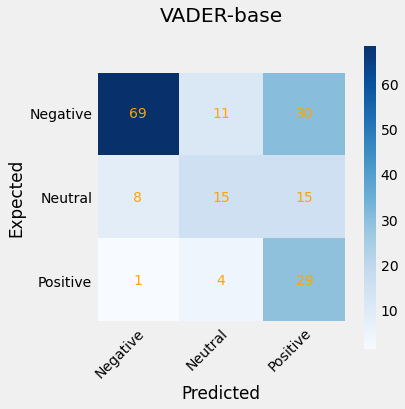

In [7]:
# Get the ground truth as a list
y_true_test = list(y_test["y_sent"])

# Get the prediction list
y_pred_VADERbase = list(y_pred_VADERbase)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-base", y_true=y_true_test, y_pred=y_pred_VADERbase, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-base", y_true=y_true_test, y_pred=y_pred_VADERbase, labels=[0,1,2])

Let's try to think about what that means.

In [8]:
# Create the df with compound score, prediction, and ground truth labels
vaderBase_df = pd.DataFrame()
vaderBase_df['x_compound_VADERbase'] = x_compound_VADERbase
vaderBase_df['y_pred_VADERbase'] = y_pred_VADERbase
vaderBase_df['y_true_test'] = y_true_test

print(vaderBase_df.shape)
vaderBase_df.head()

(182, 3)


,x_compound_VADERbase,y_pred_VADERbase,y_true_test
0,0.7579,2,1
1,0.0000,1,1
2,-0.6988,0,0
3,0.3290,2,0
4,0.2960,2,2


In [9]:
vaderBase_df.groupby('y_true_test')['x_compound_VADERbase'].describe()

,count,mean,std,min,25%,50%,75%,max
y_true_test,,,,,,,,
0,110.0,-0.226029,0.552149,-0.9559,-0.70030,-0.34000,0.225775,0.8919
1,38.0,0.065600,0.351207,-0.7469,0.00000,0.00000,0.306950,0.7579
2,34.0,0.491376,0.357922,-0.6908,0.32365,0.49365,0.833775,0.9246


So, the average VADER compound score, per class, is:
* 0: negative: -0.2260
  * true negatives have an avaerage VADER score of -0.2260; seems reasonable to high
  * sd is very wide, 0.55, for a span of -1 to 1
  * there are some true negatives that score very high: 0.8919
* 1: neutral: 0.0656
  * in general, the model is scoring them too high (cutoff is 0.05/-0.05)
  * there are some true neutrals that score high: 0.7579
  * there are some true neutrals that score low: -0.7469
* 2: positive: 0.4914 
  * true positives have an avaerage VADER score of 0.4914; seems reasonable to high
  * there are some true positives that score low: -0.6908

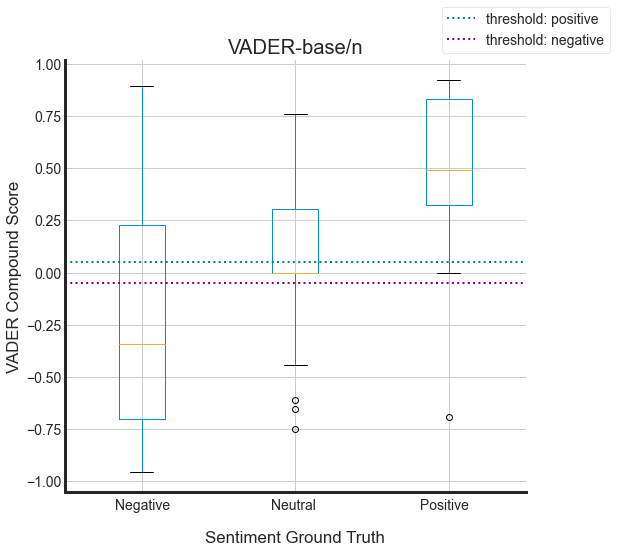

In [18]:
#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
aa.boxplot_results(model_name="VADER-base", df=vaderBase_df, score_col='x_compound_VADERbase', y_true_col="y_true_test", pos_threshold=0.05, neg_threshold=-0.05)

So, the bulk (50% boxes) of the positives and negatives are separated, but the neutral is not well separated at all. 

And the negative (class 0) is spanning a LOT of ground, while the positive (class 2) has a clear outlier.

We need more separation before we can choose good threshhold values. Though I imagine we could do a bit better even now, just by choosing 0 and 0.27-ish as our thresholds.

In [19]:
# Save the VADER-base predictions dataframe to csv
vaderBase_df.to_csv("dataVader/vaderBasePreds_df.csv")

# Data Prep
VADER should do better if we get the input into better shape.

### What if we use the Content v. ContentClean column that we used for labeling?
Remember that VADER has its own way of dealing with punctuation, capitalization, modifiers, negations, stopwords, tokenization and lemmatization. Earlier cleaning was done to try not to mess with that. I tested to make sure that was done correctly. The scores are the same, either set. This code has been moved to the graveyard.

(A nice tutorial explaining this: https://towardsdatascience.com/are-you-scared-vader-understanding-how-nlp-pre-processing-impacts-vader-scoring-4f4edadbc91d)

## Emoji
ref: vaderEmoji.ipynb

So, how does VADER actually handel some of these emoji?

In [20]:
sid = SentimentIntensityAnalyzer()

txt = "I strongly support your relocation from Afgh."
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. 👍"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. :thumbs_up:"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs up."
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs up!"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. Thumbs down!"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. !"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. :)"
print(aa.vader_sent_compound(txt))
txt = "I strongly support your relocation from Afgh. 🤣"
print(aa.vader_sent_compound(txt))

print()

txt = "I hate your relocation from Afgh."
print(aa.vader_sent_compound(txt))
txt = "I hate your relocation from Afgh. Thumbs down"
print(aa.vader_sent_compound(txt))
txt = "I hate your relocation from Afgh. Thumbs down!"
print(aa.vader_sent_compound(txt))

0.5859
0.5859
0.5859
0.5859
0.6239
0.6239
0.6239
0.7783
0.7906

-0.5719
-0.5719
-0.6114


Note that all four of the first sentences get the same score. But when we add ":)", the score jumps up.

Note that 🤣 is scored but 👍 is not.

Adding an exclamation point increases the score, but unfortunately it doesn't distinguish between up and down. I think it's just giving the score a boost for the "!". Yep, it is.

So... How many and what scores does VADER give?

In [21]:
emoji_df_full["VADERscore"] = emoji_df_full["emoji"].apply(aa.vader_sent_compound)
print(emoji_df_full["VADERscore"].value_counts())
emoji_df_full

NameError: name 'emoji_df_full' is not defined

Well, it gets some (165 of 1106) of them, but misses (941) a few that might be important to us (🤡, for example)

And some are really not correct for our data:
* 💔, :broken_heart:, 0.2732 --> -0.2732
* 😔, :pensive_face:, 0.0772 --> -0.1
* 😥, :sad_but_relieved_face: 0.3291 --> -0.1

There are a few ways we could deal with this.
1. Take the emojized version and transform it so 👍 --> Thumbs up!  (or just "!", it's the same score)
2. Translate to keyboard emoji, so 👍 --> :)
3. Add the emoji to the dictionary and give them our own score.
4. Add the emoji to the dictionary, but give them emosent scores (https://pypi.org/project/emosent-py/)

Trying a fw out on just the labeled dataset.

Of these, I think my best bet is #1. It's not perfect, but it requires the fewest assumptions and thus the least validating. Start there.

In [ ]:
text = "I strongly support 👍your relocation from Afgh.👍"
print(text)
print(aa.vader_sent_compound(text))

text = aa.emojiToExcl(text)
print()
print(text)
print(aa.vader_sent_compound(text))

In [ ]:
tweets_clean['ContentCleanEx'] = tweets_clean['ContentClean'].apply(aa.emojiToExcl)

In [ ]:
print(aa.term_check("❤️", tweets_clean, text_col="ContentClean"))
print(aa.term_check("❤️", tweets_clean, text_col="ContentCleanEx"))
print(aa.term_check("!", tweets_clean, text_col="ContentClean"))
print(aa.term_check("!", tweets_clean, text_col="ContentCleanEx"))

In [ ]:
tweets_clean["VADERsid"] = tweets_clean["ContentCleanEx"].apply(aa.vader_sid)
tweets_clean["VADERcompound"] = tweets_clean["ContentCleanEx"].apply(aa.vader_sent_compound)
tweets_clean["VADERpred"] = tweets_clean["ContentCleanEx"].apply(aa.vader_pred)

# Get the prediction and the grounttruth as lists
demoji_pred = list(tweets_clean["VADERpred"])
true = list(tweets_clean["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=demoji_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=demoji_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-excl F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-excl F-score, macro average: {:04.3f}'.format(base_macroF1))

In [ ]:
## DEL: duplicate of above?
x_train["VADERsid"] = x_train["ContentClean"].apply(vader_sid)
x_train["VADERcompound"] = x_train["ContentClean"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["ContentClean"].apply(vader_pred)

# Get the prediction and the grounttruth as lists
demoji_pred = list(x_train["VADERpred"])
true = list(y_train_sent["y_sent"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=demoji_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=demoji_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-demoji F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-demoji F-score, macro average: {:04.3f}'.format(base_macroF1))

Well, that actually made it a tiny bit worse, still below the baseline.

VADER-base, untuned
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

Emoji to Exclamation
* VADER-demoji F-score, micro average: 0.542
* VADER-demoji F-score, macro average: 0.501

I'm guessing that is because the way I have done it, the exclamation point just pushes the score a bit further in the direction it was going anyway. Since the neutral category is so small to begin with, this just doesn't do much. 

But at the same time, I did this for ALL emojis, so it lost the validated score on the few emojis that VADER did know.

This is not a good approach. 

In [ ]:
tweets_clean.drop("ContentCleanEx", axis=1, inplace=True)
tweets_clean.head()

### Emosent
Will the emosent package work for me?

In [ ]:
emoji_df_full["emosentScore"] = emoji_df_full["emoji"].apply(aa.emosent_score)
emoji_df_full

# CITE: Sentiment of Emojis, Nova et. al.

In [ ]:
print(emoji_df_full["emosentScore"].value_counts())

Kinda. It has about half (missing 638) . But it seems to miss some of the important ones that I need. 
* 🤷, 🤮, etc.

And for the symbols where they overlap, the VADER and emosent scores do necessarilly agree and are sometimes very far off:
* 💔 (broken_heart): 0.2732 v. -0.122
* 😭 (loudly_crying_face): -0.4767 v. -0.093

And some of the values are just off for __this__ dataset. For example, the stack of dollars (💵) has a emosent score of 0.423 - very high. Which makes sense normally: money is good. But in this dataset, it shows up when people are stressing the overly high cost of refugee or ilitary operations, or are talking about corruption. 

As this tool has been validated, I'll consider the values they have. But I'll still have to assign my own values to the remaining half. So: first VADER; if not, then emosent; if not, then my ranking; and my own ranking for emojis that are used differently than normal in my dataset.

NOTE: I will have to add the emosent and my emojis to the dictionary. 
* For more insight on ranking: http://kt.ijs.si/data/Emoji_sentiment_ranking/

NOTE: There is a LOT more that could be done with emojis in terms of: 
* setting sentiment scores for all emoji that appear in the dataet, not just in my labeled subset.
* identifying news articles and other irrelevant rows in the data.

For now, write them to a CSV file for later labeling.

In [ ]:
emoji_df.to_csv(os.path.join('dataVader', "emoji_score.csv"))
#emoji_df_full.to_csv(os.path.join('dataVader', "emoji_score_full.csv"))

For now, let's reload the data and move on.
### PAUSE / UNPAUSE

In [ ]:
# Unpause
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADER.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADER.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

# Word Clouds
__NOTE: There is a lot of preprocessing below that is ONLY used to make the wordclouds. VADER has it's own way of dealing with things like punctuation, capitalization, stopwords, tokenization, lemmatization. And we don't necessarilly want to mass with / override that without validating.__

In order to refine the dictionaries, I need to know what words and bigrams/trigrams are common in which datasets. So let's make word clouds.

First I need to create a single text per pos, neg, and neutral. Then I can feed them into wordcloud. I think I'll use the full dataset to generate one, too.

I don't have a preexisting df for this, so I'm going to have to rebuild it. Sigh.

First just all the ContentClean

In [ ]:
# SETUP

# changes to tokenizer and lemmatizer --> UPDATE in aardvark, too.
w_tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#stopwords = list(STOPWORDS) + ["Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now"]
stopwords = nltkStop.words('english') + ["Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "say", "like", "via"]

In [ ]:
# start from the two sets - unlabeled and labeled - that were created in dataCleaningB
all_l = pd.read_csv("all_labeled_tweets.csv", header=0, index_col=0)
all_u = pd.read_csv("all_unlabeled_tweets.csv", header=0, index_col=0)
print(list(all_l.columns))
print(list(all_u.columns))

In [ ]:
l_list = ['Content','Labels', 'label_sent', 'y_sent', 'label_stance', 'y_stance', 'Flag', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags']
all_l.drop(l_list, axis=1, inplace=True)
print(list(all_l.columns))

u_list = ['Content', 'Flag']
all_u.drop(u_list, axis=1, inplace=True)
print(list(all_u.columns))

In [ ]:
#NOTE that I'm ordering here by date. Not sure why...

frames = [all_l, all_u]
master_tweets = pd.concat(frames)
master_tweets.sort_values(by=['Date'], inplace=True)
master_tweets.reset_index(drop=True, inplace=True)
print(master_tweets.shape)
master_tweets.tail()

### PAUSE / UNPAUSE

In [ ]:
# Pause
master_tweets.to_csv(os.path.join('dataVader', "master_tweets.csv"))

In [ ]:
# Unpause
master_tweets = pd.read_csv(os.path.join('dataVader', "master_tweets.csv"), header=0, index_col=0)

### Full Data Wordcloud
from the full dataset, stopwords removed

In [ ]:
# Thanks to: https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html
train_words = ' '.join(master_tweets["ContentClean"])
a = aa.lemmatize_text(train_words)
lem_words = ' '.join(a)

In [ ]:
# CITE: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words)
all_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

# Word cloud by label
Now the labeled data, divied up by label.

In [ ]:
all_xy = pd.read_csv(os.path.join('data', "all_labeled_tweets.csv"), header=0, index_col=0)
print(list(all_xy.columns))

In [ ]:
d = ['Content', 'Labels', 'label_sent', 'label_stance', 'y_stance', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Flag']
master_labeled = all_xy.drop(d, axis=1)
master_labeled.sort_values(by=['Date'], inplace=True)
master_labeled.reset_index(drop=True, inplace=True)
print(master_labeled.shape)
master_labeled.tail()

In [ ]:
labeled_zero = master_labeled[master_labeled["y_sent"]==0].copy()  # neu
labeled_one = master_labeled[master_labeled["y_sent"]==1].copy()  # neg
labeled_two = master_labeled[master_labeled["y_sent"]==2].copy()  # pos
print(labeled_zero.shape)
print(labeled_one.shape)
print(labeled_two.shape)

### PAUSE / UNPAUSE

In [ ]:
# Pause
master_labeled.to_csv(os.path.join('dataVader', "master_labelel.csv"))
labeled_zero.to_csv(os.path.join('dataVader', "labeled_zero.csv"))
labeled_one.to_csv(os.path.join('dataVader', "labeled_one.csv"))
labeled_two.to_csv(os.path.join('dataVader', "labeled_two.csv"))

### Preprocess for wordcloud: Tokenize and Lemmatize 

In [ ]:
zero_words = ' '.join(labeled_zero["ContentClean"])
zero_lem = aa.lemmatize_text(zero_words)
zero_lem = ' '.join(zero_lem)

one_words = ' '.join(labeled_one["ContentClean"])
one_lem = aa.lemmatize_text(one_words)
one_lem = ' '.join(one_lem)

two_words = ' '.join(labeled_two["ContentClean"])
two_lem = aa.lemmatize_text(two_words)
two_lem = ' '.join(two_lem)

In [ ]:
# Neutral
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(zero_lem)
neu_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
# Negative
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(one_lem)
neg_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
# Positive
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(two_lem)
pos_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

Significant in all three:
* asylum (this is surprising)
* "ha" is in both pos and neg. Does Vader catch this as sarcastic in the neg? This should be an intensifier, not a sentiment.

Add negiative score to:
* Taliban
* unvetted
* left behind
* crisis

Add positive score to:
* community
* help/ing (and why are these not fied by the lemmatizer?)
* family (this is in neutral too, but I think it might help w positive)
* resettlement (this is in neg, but really small... and in neu, maybe slightly positive)
* Thank
* welcome
* support
* opportunity

### Bigrams and Trigrams

In [ ]:
# Neutral - up to trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(zero_lem)
neu_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = zero_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neu = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neu, tri_neu = aa.bi_tri_freq(ngram_text_neu)
print("Neutral nGrams")
print(bi_neu[:25])
print()
print(tri_neu[:25])


In [ ]:
# Negative, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(one_lem)
neg_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = one_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_neg = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_neg, tri_neg = aa.bi_tri_freq(ngram_text_neg)
print("Negative nGrams")
print(bi_neg[:25])
print()
print(tri_neg[:25])


In [ ]:
# Positive, trigrams allowed
wc = WordCloud(stopwords=stopwords, width=900, height=500, collocation_threshold = 3, max_words=30).generate(two_lem)
pos_bi_wc = wc.words_  # dictionary of the words used to make the cloud
plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [ ]:
punct = '%&\()*,./:;<=>[\\]^_`{|}~!?#0123456789'

# starting from zero_lem, which was tokenized and lematized above, but stopwords were 
# not removed (used wordcloud's stopword remover). Clean it up for ngrams
ngram_text = two_lem.replace("_", " ")
ngram_text = [word.strip(punct) for word in ngram_text.split()]
ngram_text = [word for word in ngram_text if word not in stopwords]  # remove stopwords
ngram_text = [s for s in ngram_text if len(s) != 0]  # remove empties
ngram_text_pos = ' '.join(ngram_text)

# find frequency of the bi/trigrams
bi_pos, tri_pos = aa.bi_tri_freq(ngram_text_pos)
print("Neutral nGrams")
print(bi_pos[:15])
print()
print(tri_pos[:15])

In [ ]:
# dictionary of the words used to make the cloud
neu_wc
neu_words = []
for key, val in neu_wc.items():
    neu_words.append(key)

neu_bi_wc
neu_bigs = []
for key, val in neu_bi_wc.items():
    neu_bigs.append(key)

neg_wc
neg_words = []
for key, val in neg_wc.items():
    neg_words.append(key)

neg_bi_wc
neg_bigs = []
for key, val in neg_bi_wc.items():
    neg_bigs.append(key)

pos_wc
pos_words = []
for key, val in pos_wc.items():
    pos_words.append(key)

pos_bi_wc
pos_bigs = []
for key, val in pos_bi_wc.items():
    pos_bigs.append(key)

wc_words = pd.DataFrame({"neu words":neu_words, "neg words":neg_words, "pos words":pos_words, "neu nGrams":neu_bigs, "neg nGrams":neg_bigs, "pos nGrams":pos_bigs})
wc_words[:15]

In [ ]:
print("Neutral nGrams")
print(bi_neu[:10])
print(tri_neu[:10])
print()
print("Negative nGrams")
print(bi_neg[:10])
print(tri_neg[:10])
print()
print("Positive nGrams")
print(bi_pos[:10])
print(tri_pos[:10])


In [ ]:
# Should have included this in the aardvark function. Oh well.
from sklearn.feature_extraction.text import CountVectorizer

words_in_text = list(ngrams(ngram_text_neu.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Neutral Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_neg.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Negative Tweets")
print(words_in_text_freq[:25])
print()

words_in_text = list(ngrams(ngram_text_pos.split(), 1))
words_in_text = [' '.join(i) for i in words_in_text]
vectorizer = CountVectorizer(ngram_range=(1, 1))
bag_of_words = vectorizer.fit_transform(words_in_text)
vectorizer.vocabulary_
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_in_text_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
print("Frequent Words: Positive Tweets")
print(words_in_text_freq[:25])

In [ ]:
# Alternate approach: easier code, messier results.
from nltk.probability import FreqDist
pos_tok = ngram_text_pos.split(" ")
fdist = FreqDist(pos_tok)
fdist = fdist.most_common(5)
fdist

In [ ]:
# check_tweets = pd.read_csv(os.path.join('dataVader', "master_labelel.csv"), index_col=0, header=0)
check_tweets = pd.read_csv(os.path.join('dataVader', "master_tweets.csv"), index_col=0, header=0)


### ALTERNATE term check

In [ ]:
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🔜" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count
# Orig: left behind: 3992 instances in master_tweets

In [ ]:
vader_sent_compound("embarrassing")

# Adding to VADER
### Stop Words 
VADER takes care of stop word removal. I would to refine what is considered a stopword, but that's surprisingly complicated. So instead we are going to change the lexicon to make the relevant words score = 0.

Add: all the ones that were used for WordCloud: "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"

Also: "asylum", "seeker", "special", "family", "country"

In [ ]:
sid = SentimentIntensityAnalyzer()
change_lex = {}

In [ ]:
check_list = ["asylum", "seeker", "special", "family", "country", "Afghan", "Afghans", "Afghanistan", "refugee", "refugees", "U", "S", "US", "people", "will", "now", "UK", "wa", "ha", "say", "like", "via"]
for i in check_list:
    print(i, ":", vader_sent_compound(i))  #💩

In [ ]:
change_lex["special"]=0
change_lex["like"] = 0
change_lex["ha"] = 0
sid.lexicon.update(change_lex)
# "ha" is in both pos and neg (sarcastic); this should be an intensifier, not a sentiment.

### New Dictionary terms
emojis

negative: left behind, unvetted, Taliban, Osama bin Laden, crisis

Positive: soccer, citizen, help, support, thank, welcome, hope

Neutral: resettle, resettlement

#thanks: https://stackoverflow.com/questions/40481348/is-it-possible-to-edit-nltks-vader-sentiment-lexicon

In [ ]:
check_list = ["left behind", "unvetted", "Taliban", "Laden", "crisis", "soccer", "citizen", "help", "support", "thank", "welcome", "hope", "resettle", "resettlement"]

for i in check_list:
    print(i, ":", vader_sent_compound(i))

In [ ]:
change_lex["left behind"] = -3
change_lex["unvetted"] = -2
change_lex["taliban"] = -1
change_lex["laden"] = -1  # In the full dataset, there are 123 " bin laden"s and 156 "laden"s; most of these are made up by just the most obvious misspellings (#osamabin: 6; binladen: 11; ben laden: 1). Good enough.
change_lex["soccer"] = 1
change_lex["citizen"] = 1
sid.lexicon.update(change_lex)

"left behind" needs to be changed into a single word for VADER to score it appropriately.

In [ ]:
print(vader_sent_compound("left behind"))
change_lex["left_behind"] = 2
sid.lexicon.update(change_lex)
vader_sent_compound("left_behind")

In [ ]:
my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

my_count = 0
for id, text in zip(check_tweets.id_stable, x_train["ContentClean"]):
    if "left_behind" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        #print(id, ":", text)
        my_count += 1
print(my_count)

In [ ]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    x_train.loc[i, ["ContentClean"]] = text.lower().replace('left behind', 'left_behind')

### Now find the score

In [ ]:
x_train.drop(columns = ["VADERsid", "VADERcompound", "VADERpred"], axis = 1, inplace = True)
x_train.head()

In [ ]:

# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())


In [ ]:
# Use the same "true" as above
# Get the prediction list
lex1_pred = list(x_train["VADERpred"])

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex1_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex1_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER_lex1 F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER_lex1 F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

This is a little bit better, but really not much. And not over the baseline.
* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521


In [ ]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

In [ ]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

In [ ]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

### PAUSE / UNPAUSE

In [ ]:
# PAUSE
x_train.to_csv(os.path.join('dataVader', "x_train_VADERlex.csv"))
#x_val.to_csv(os.path.join('dataVader', "x_val_VADERlex.csv"))   NOT done yet 


In [ ]:
# UNPAUSE
x_train = pd.read_csv(os.path.join('dataVader', "x_train_VADERlex.csv"), header=0, index_col=0)
x_val = pd.read_csv(os.path.join('dataVader', "x_val_VADERlex.csv"), header=0, index_col=0)
y_train_sent = pd.read_csv(os.path.join('data', "y_train_sent.csv"), header=0, index_col=0)
y_val_sent = pd.read_csv(os.path.join('data', "y_val_sent.csv"), header=0, index_col=0)

### Add new emojis to the lexicon

In [ ]:
emoji_df = pd.read_csv(os.path.join('dataVader', "emoji_score.csv"), header=0, index_col=0)
emoji_lex = emoji_df[emoji_df["VADERscore"]==0].copy()
emoji_lex.drop("VADERscore", axis=1, inplace=True)
emoji_lex.head()

I'm going to do the scoring in Excel.

In [ ]:
emoji_lex.to_csv("emoji_lex.csv")

In [ ]:
emoji_lex2 = pd.read_csv(os.path.join('dataVader', "emoji_lex_myScore.csv"), header=0, index_col=0)
emoji_lex2.tail()

# emoji_lex2 = pd.read_csv("emoji_lex.csv", header=0, index_col=0)

So, apparently VADER transforms emoji to text before extracting sentiment. I'm not exactly sure how this works: since it seems to map emoji to some pretty common words, I'm not sure how updating these sentiments would work. So I'm going to do the word transformation myself, then add those words to the lexicon with my scores.

In [ ]:
# del emoji_lex
# del emoji_lex2

In [ ]:
frames = [emoji_lex, emoji_lex2]
emoji_lex = pd.concat(frames, axis=1)
# emoji_lex.drop(columns=["demoji", "emosentScore"], inplace=True)
emoji_lex.drop(columns=["emoji", "demoji", "emosentScore"], inplace=True)
emoji_lex = emoji_lex[emoji_lex["lexScore"] != 0]
emoji_lex = dict(zip(emoji_lex["name"], emoji_lex["lexScore"]))
emoji_lex

In [ ]:
sid.lexicon.update(emoji_lex)

In [ ]:
print(vader_sent_compound("person_shrugging"))
print(vader_sent_compound("clown_face"))
print(vader_sent_compound("my_broken_heart"))

So that works to update VADER.

Now to make the transformation in the data.

In [ ]:
a = emoji_df[emoji_df["VADERscore"]==0].copy()
a.drop("VADERscore", axis=1, inplace=True)
a.tail()

In [ ]:
frames = [a, emoji_lex2]
emoji_dataUpdate = pd.concat(frames, axis=1)
emoji_dataUpdate.tail()

In [ ]:
emoji_dataUpdate.loc[70, "emoji"] = "💔"
emoji_dataUpdate.loc[71, "emoji"] = "😔"
emoji_dataUpdate.loc[72, "emoji"] = "😥"
emoji_dataUpdate.tail()

In [ ]:
emoji_dataUpdate.drop(columns=["demoji", "emosentScore", "lexScore"], inplace=True)
emoji_dataUpdate.tail()

### PAUSE / UNPAUSE

In [ ]:
x_train.to_csv(os.path.join('dataVader', "temp_x_train.csv"))

In [ ]:
x_train = pd.read_csv(os.path.join('dataVader', "temp_x_train.csv"), index_col=0, header=0)
x_train.tail()

### Cont.

In [ ]:
print(aa.term_check("💀", x_train))  #💀 sk_ull
print(aa.term_check("sk_ull", x_train))  #💀 sk_ull
print(aa.term_check("💔", x_train))
print(aa.term_check("my_broken_heart", x_train))

aa.term_check("person_shrugging", x_train)


In [ ]:
for i, text in zip(x_train.index, x_train["ContentClean"]):
    if "‼️" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("‼️", "!!")
    if "👊" in text:
        x_train.loc[i, ["ContentClean"]] = text.replace("👊", "!")
    for emj, nme in zip(emoji_dataUpdate["emoji"], emoji_dataUpdate["name"]):
        if emj in text:
            x_train.loc[i, ["ContentClean"]] = text.replace(emj, str(" "+nme+" "))
    

## Find new scores

In [ ]:
# sid.lexicon.update(change_lex)
print(vader_sent_compound("left_behind"))
print(vader_sent_compound("💀"))
print(vader_sent_compound("sk_ull"))
print(vader_sent_compound("💔"))
print(vader_sent_compound("my_broken_heart"))
print(vader_sent_compound("person_shrugging"))

In [ ]:
# x_train.drop(columns=["VADERsid", "VADERcompound", "VADERpred"], axis=1, inplace=True)
# x_train.head()

In [ ]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

In [ ]:
# Use the same "true" as above
# Get the prediction list
lex2_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=lex2_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=lex2_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-base w emoji lexicon, F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-base w emoji lexicon, F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

In [ ]:
frames = [x_train, y_train_sent]
train_temp = pd.concat(frames, axis=1)
train_temp.drop(["Date", "Content", "ContentClean", "VADERsid"], axis=1, inplace=True)
train_temp = train_temp.iloc [:, [0, 1, 2, 4]]  
train_temp.columns = ["id_stable", "VADERcompound", "VADERpred", "GroundTruth"]
print(train_temp.shape)

In [ ]:
train_temp.groupby('GroundTruth')['VADERcompound'].describe()

In [ ]:
print("VADER Compound Score grouped by Ground Truth")
train_temp.boxplot(by='GroundTruth', column='VADERcompound', figsize=(10,8))

So, this changes NOTHING. I guess not many rows have emojis, and/or those rows were already predicted correctly.

* Underpredicting neutral
* Underpredicting negative
* Overpredicting positive

Baseline: Majority Class Prediction
* Majority class prediction F-score, micro average: 0.606
* Majority class prediction F-score, macro average: 0.252

VADER-base, untuned:
* VADER-base F-score, micro average: 0.543
* VADER-base F-score, macro average: 0.502

VADER-base, lexicon with updated sentiment terms
* VADER_lex_ F-score, micro average: 0.563
* VADER_lex_ F-score, macro average: 0.521

VADER-base w emoji lexicon
* VADER-base w emoji lexicon, F-score, micro average: 0.563
* VADER-base w emoji lexicon, F-score, macro average: 0.521


# Find and Remove more News
Ok, so we discovered when dealing with the emojis that several of them are reliable indicators of news articles or other irrelevant rows:
* 🎙️: audio broadcasts, esp. podcasts
* 🆕: new infomration
* 📡: on the radar
* 📊: data given
* 📅: event schedule   #DO THIS ONE LATER


In [ ]:
## IN THE FULL DATASET
print(check_tweets.shape)
my_count = 0
for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
    if "🆕" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        print(id, ":", text)
        my_count += 1
my_count

In [ ]:
my_count=0
print(x_train.shape)
for id, text in zip(x_train.id_stable, x_train["ContentClean"]):
    if "new_button" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
        my_count += 1
my_count


In [ ]:
list = ["studio_microphone", "NEW_button", "satellite_antenna", "bar_chart"]
indx_list = []
# for i, text in zip(x_train.index, x_train["ContentClean"]):
#     for emj in list:
#         if emj in text:
#             indx_list.append(i)
for id, text in zip(x_train.index, x_train["ContentClean"]):
    if "bar_chart" in text:
        print(i)

indx_list


This is not in enough rows to be worth it.

# Reset the category thresholds
I think the VADER people wanted to keep "neutral" as small as possible. That makes sense when you are talking about a simple subject. It's less useful when topics are complex (lots of pros and cons) and undecided or neutral is a viable stance to take on the subject.

So let's widen the thresholds.

In [ ]:
def vader_pred_var(tweet):
    scores = sid.polarity_scores(tweet)
    comp = scores["compound"]
    if comp >= 0.1:
        return 2
    elif comp <= -.01:
        return 1
    else:
        return 0

In [ ]:
# Use the functions to stick it all into the df
x_train["VADERsid"] = x_train["Content"].apply(vader_sid)
x_train["VADERcompound"] = x_train["Content"].apply(vader_sent_compound)
x_train["VADERpred"] = x_train["Content"].apply(vader_pred_var)

print("Ground Truth:")
print(y_train_sent["y_sent"].value_counts())
print("Pred:")
print(x_train["VADERpred"].value_counts())

In [ ]:
# Use the same "true" as above
# Get the prediction list
threshold_pred = x_train["VADERpred"].tolist()

# Find the microaverage of the F1 scores
base_microF1 = f1_score(y_true=true, y_pred=threshold_pred, average='micro', zero_division='warn')
base_macroF1 = f1_score(y_true=true, y_pred=threshold_pred, average='macro', zero_division='warn')

print("Micro and Macro-Average")
print('\tVADER-threshold F-score, micro average: {:04.3f}'.format(base_microF1))
print('\tVADER-threshold F-score, macro average: {:04.3f}'.format(base_macroF1))
print()

So, disappointingly, this also does very little. Because there is so much overlap, moving the threshold may help one class, but it will about equally hurt another. There has to be better separation betwteen classes in order for this to work.

NOTE: no need for boxplots, as the distribution hasn't changed.

Unfortunately, I think I have to leave the analysis there and move on to writeup. I don't have time to keep working on this now.

# Now make the selected transformations on the validate data and the full dataset.
* sid.lexicon.update(change_lex)
* replace "left behind" with "left_behind"
* replace new emojis with the text equivalent in 

# TO CONSIDER, esp. for BERT
* expand contractions
* remove links, URLs
* Replace emoji w standard text
* What to do with hashtags
* remove capitalization 
* What to do with punctuation: ! or ? should be useful for sentiment. Maybe " " for sarcasm?
* remove whitespaces
* Bertmoticon package, which is fine-tuned to the BERT model.
* remove stop words beyond the standard NLTK stop words
    * Create WordClouds to find prominant but useless words
    * Ex: days of the week and their abbreviations, month names, and the word “Twitter” 
* deal w negations
    * create a dictionary of negations so that negated words could be effectively handled
* tokenize 
* stemming (via PorterStemmer)
* REMEMBER:
    * Hashtags is filled with "No hashtags"
    * Location is filled with "English-speaking"